In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Download the codeSearchNetChallenge dataset 
_If needed_

In [2]:
%run downloading_cleaning_codeSearchNetChallenge_dataset.ipynb

CodeSearchNet challenge dataset ready to use!


## Exporting the codeSearchNetChallenge dataset to CSV files

_If needed_

In [3]:
%run preparing_csv_files_from_codeSearchNetChallenge_dataset.ipynb

Total lines of Python code in the dataset (after removing empty lines)
11206193


Total lines of Python code in the dataset's train folder (after removing empty lines)
10054266


Total lines of Python in the dataset's test folder (after removing empty lines)
541338


Total lines of Python in the dataset's valid folder
610589


## Training tokenizer using SentencePiece

_model_type=char_

In [4]:
import torch
torch.cuda.set_device(1)
print ('Current cuda device in use: ', torch.cuda.current_device())

Current cuda device in use:  1


In [5]:
from fastai.text import *
import sentencepiece as spm #https://github.com/google/sentencepiece
import os

In [6]:
from tokenizer_utils import CustomTokenizer, SPTokenizer

In [29]:
vocab_size = 600
model_prefix = 'char_clean_code_challenge_model'

In [30]:
codeSearchNet_challenge_path = './CodeSearchNet_challenge_dataset'
all_csv_path = './CodeSearchNet_challenge_dataset/CodeSearchNet_challenge_dataset.csv'
train_csv_path = './CodeSearchNet_challenge_dataset/python/final/jsonl/train/train_CodeSearchNet_challenge_dataset.csv'
test_csv_path = './CodeSearchNet_challenge_dataset/python/final/jsonl/test/test_CodeSearchNet_challenge_dataset.csv'
valid_csv_path = './CodeSearchNet_challenge_dataset/python/final/jsonl/valid/valid_CodeSearchNet_challenge_dataset.csv'

In [31]:
spm.SentencePieceTrainer.Train(f'--input={all_csv_path}'\
                               f' --model_prefix={model_prefix}'\
                               f' --vocab_size={vocab_size}'\
                               f' --model_type=char'\
                               f' --unk_piece={UNK} --bos_piece={BOS} --eos_id=-1 --pad_piece={PAD}')

In [32]:
## load up the Processor
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')

True

In [11]:
itos = []
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])

In [12]:
mycust_tok = CustomTokenizer(SPTokenizer, model_prefix)

In [13]:
#setup Vocab object for use in LM
sp_vocab = Vocab(itos)

In [14]:
if not os.path.exists('20200811_char_model_databunch_data_save_temp.pkl'):

    data = TextLMDataBunch.from_csv('./', train_csv_path, test=test_csv_path, tokenizer=mycust_tok, vocab=sp_vocab)
    data.save('20200811_char_model_databunch_data_save.pkl')
    data.show_batch()

In [15]:
data = load_data('./', '20200811_char_model_databunch_data_save_temp.pkl', bs=1600)

/opt/tljh/user/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [16]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [17]:
print(learn.model)

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(91, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(91, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=91, bias=True)
    (output_dp): RNNDropout()
  )
)


In [18]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 91]             36,491     True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 36,491
Total trainable params: 36,491
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function :

In [19]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02
Min loss divided by 10: 9.12E-02


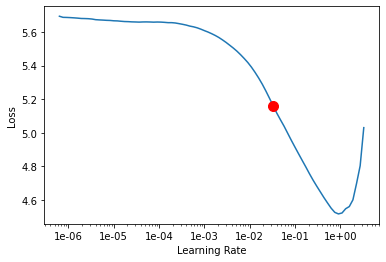

In [20]:
learn.recorder.plot(suggestion=True)

In [21]:
learn.fit_one_cycle(1, slice(1e-1, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.194255,2.017406,0.449953,24:27


In [22]:
learn.save('20200811_fit_head_char_model_drop_mult')

In [23]:
learn.load('20200811_fit_head_char_model_drop_mult');

In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(30, slice(1e-1, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.963516,0.924853,0.730255,34:41
1,0.907281,0.890260,0.739244,34:40
2,0.931071,0.908255,0.734802,34:41
3,0.951778,0.927017,0.730146,34:36
4,0.971262,0.941669,0.726628,34:16
5,0.997196,0.972038,0.718408,34:02
6,1.020785,0.987118,0.714459,33:54
7,1.038034,1.008346,0.708996,33:50
8,1.016577,0.992760,0.712280,33:44
9,1.007768,0.981218,0.715330,33:49


In [26]:
learn.save('20200811_fine_tuned_char_model_drop_mult')

In [27]:
learn.load('20200811_fine_tuned_char_model_drop_mult');

In [33]:
TEXT = "import from"
N_WORDS = 25
N_SENTENCES = 3
for _ in range(N_SENTENCES):
    predicted = learn.predict(TEXT, N_WORDS, temperature=0.9)
    val = predicted.replace(TEXT, '')
    decoded = sp.decode_pieces(val.split())
    print(TEXT + " "+  decoded)

import from file, url_path if clean_u
import from list data = [] if fromrep
import from _service try: from_servic


In [34]:
print(learn.summary())

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 91]             36,491     True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 36,491
Total trainable params: 36,491
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function :

In [35]:
TEXT = "from pandas import"
N_WORDS = 25
N_SENTENCES = 5
for _ in range(N_SENTENCES):
    predicted = learn.predict(TEXT, N_WORDS, temperature=0.9)
    val = predicted.replace(TEXT, '')
    decoded = sp.decode_pieces(val.split())
    print(TEXT + " "+  decoded)

from pandas import defaults as _rp pandas =
from pandas import DataFrameEncoder if self
from pandas import OrderedDict else: passed
from pandas import sequence if type(seq1) i
from pandas import conditional_insertion as
